<a href="https://colab.research.google.com/github/G-Vida/Machine_Learning/blob/main/Copia_di_Esercitazione__CNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLME: Convolutional neural networks

In this lesson, we will cover:

- Convolutional neural networks
- Residual networks

Based on original material by Dr. Luca Moschella, Dr. Antonio Norelli and Dr. Marco Fumero.


Are powerful but hard to train!

## What you can expect from your experience with CNNs

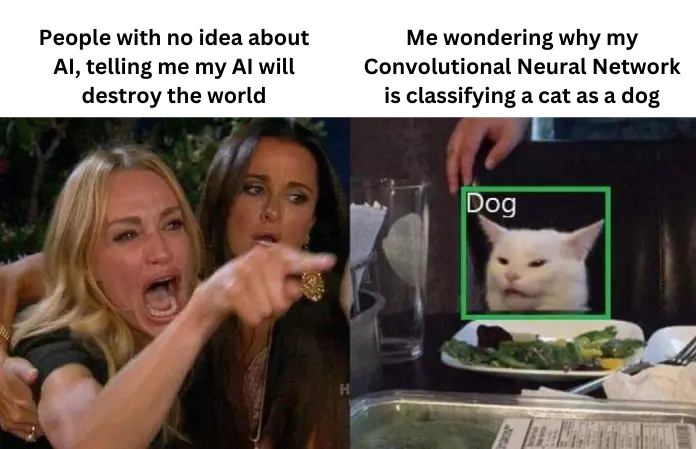

##Introduction to CNNs

Today we start by going back to March 2016.

Do you remember this match?

![AlphaGo](https://mediad.publicbroadcasting.net/p/shared/npr/201805/470700854.jpg)



For the first time an artificial intelligence defeated a Go world champion, Lee Sedol, a feat that was previously believed to be at least a decade away.
This event is already a milestone in AI research.

A fundamental ingredient of AlphaGo was a neural network architecture that at that time was already revolutionizing the field of computer vision; Convolutional Neural Networks.

The huge complexity of the patterns on a Go board was caught with success using the same general priors proved to be effective in classifying real world images.


Today we will explore this architecture and one of its evolution, Residual Convolutional Neural Networks, the one used in AlphaGo.

If you want to re-experience the AI conquer of the most ancient of games, a very nice documentary about that match is now [free on YouTube](https://www.youtube.com/watch?v=WXuK6gekU1Y)!



##Import dependencies (run the following cells)

In [ ]:
!pip install plotly==5.3.1
!pip install numpy==1.23.0

In [ ]:
# @title import dependencies

from typing import Mapping, Union, Optional

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import torchvision
from torchvision import datasets, models, transforms
import os
from tqdm.notebook import tqdm

from __future__ import print_function, division

In [ ]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

##CNNs: a fundamental idea at the core of deep learning

Convolutional neural networks are a way of exploiting a known prior about our problem. Actually, a whole set of priors at the same time:
- Translational equivariance
- Compositionality
- Locality
- Self-similarity

> Consider the problem of recognizing objects in images. Looking at the following example, how do all these priors apply.
>
>![polyfit matrix notation](https://drive.google.com/uc?export=view&id=1SLeKcN9EAYhy98aaPjxfS7uRyypSSwKS)

- Translational equivariance: A book in the upper left corner is still a book if it is in the down right corner.
- Compositionality: The table is composed by legs, recognizing the legs helps in recognizing the table.
- Locality: To recognize an eye you need only pixels locally concentrated in a spot on the image.
- Self-similarity: You can recognize the two eyes using a single eye-recognizer.

>Think about the convolution operation as a **fundamental idea at the core of deep learning** more than a nice trick to exploit known but not essential priors.

These priors are so general, and training a deep MLP is so hard, that a large part of deep learning applications would be not possible without CNNs.




## CNNs in practice

Building a CNN today is very easy thanks to modern deep learning programming frameworks. As you have seen in the last notebook, the `torch.nn` package reduces the introduction of a convolution transformation to a single call to a function  (e.g. ```nn.Conv2d```  for 2D data).

Nevertheless, CNNs involve many different operations, including non-trivial changes in shape of the input tensor through the layers.

Keep in mind the two basic transformations introduced by CNNs:
- Convolution

![conv](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)
- Pooling (Max pooling in the example below)

![pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

*Images from Wikipedia*



---

**Under the hood: how does a convolution work?**

Let's compute by hand a single output value of a convolution operation.

Altough simple to explain intuitively, managing and understanding how the *dimensions* involved behave in the computation can be **outstandingly** confusing. So much so, that implementing [average pooling](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) with padding and stride using only vectorized code is an interview question at big tech companies!

In [ ]:
# Define an arbitrary input tensor, i.e.: [batch, channels, w, h]
batch_size, num_channels, width, height = 1, 2, 4, 4
a = torch.arange(batch_size * num_channels * width * height).reshape(batch_size, num_channels, width, height).float()
a, a.shape

In [ ]:
# Define a convolution
c = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=2, bias=False)
c

 Let's look under the hood... somewhere there must be learnable weights...

In [ ]:
# They have shape [3, 2, 2, 2], i.e.: [out, in, kernel, kernel]
c.weight, c.weight.shape

The weights you see above are random, so don't look for any particular meaning. What we care about is the **shape** of `c`:
- We asked for $2\times 2$ kernels.
- `nn.Conv2d` creates $2$ such kernels: one per input channel.
- Convolution will be applied to each channel separately, resulting in $2$ feature maps.
- These features maps are [summed together](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
- All the above is done $3$ times: once per output channel.

As a result, the output of `nn.Conv2d` is a tensor with shape `[3, 2, 2, 2]` that will be convolved with the input.

### **INTERACTIVE CLASS!!!!**

For this part of the class we will use https://quizizz.com interactive questions.

So you are invited to join the online class through the code that will be given.

> **EXERCISE 1**
>
>What's the shape of the _output_ resulting from applying these convolutions?

Let's do a bit of unrolling to get a deeper insight into convolution.

In [ ]:
# We define custom kernel weights for the first out channel
# In this way we can easily reproduce the computation
my_custom_2dkernel_in_channel1 = torch.tensor([[ .1, .2], [-.4, -.5, ]])
my_custom_2dkernel_in_channel2 = torch.tensor([[.4, .3], [-.42, -.45, ]])

In [ ]:
my_custom_2dkernel_in_channel1, my_custom_2dkernel_in_channel1.shape

In [ ]:
my_custom_2dkernel_in_channel2, my_custom_2dkernel_in_channel2.shape

In [ ]:
# Modify the weights of the convolution

# out-channel 0, in-channel 0
c.weight.data[0, 0, ...] = my_custom_2dkernel_in_channel1

# out-channel 0, in-channel 1
c.weight.data[0, 1, ...] = my_custom_2dkernel_in_channel2

# ...accessing directly the .data attribute of a tensor by-passed some safety checks!

In [ ]:
# Let's check: the tirst out-channel is correctly set
c.weight, c.weight.shape

As we mentioned, we have a $2 \times 2$ kernel for each input channel, in this case two, and we have as many kernel pairs as we have output channels. For simplicity, we will only consider one output channel in our unrolling.

> **EXERCISE 2**
>
> Stop one second. Try to apply the convolution yourself!
>
> Here is an input image with shape `torch.Size([1, 2, 4, 4])`, i.e. `[batch, channels, w, h]`:
>
> ```python
> a = tensor([[[[ 0.,  1.,  2.,  3.],
>               [ 4.,  5.,  6.,  7.],
>               [ 8.,  9., 10., 11.],
>               [12., 13., 14., 15.]],
>     
>              [[16., 17., 18., 19.],
>               [20., 21., 22., 23.],
>               [24., 25., 26., 27.],
>               [28., 29., 30., 31.]]]])
> ```
>
> This is the kernel tensor from before, having shape `torch.Size([3, 2, 2, 2])`, i.e. `[out_channels, in_channels, kernel_size, kernel_size]`:
>
> ```python
> c.weight = tensor([[[[ 0.1000,  0.2000],
>                      [-0.4000, -0.5000]],
>            
>                     [[ 0.4000,  0.3000],
>                      [-0.4200, -0.4500]]],
>            
>            
>                    [[[-0.3517,  0.2366],
>                      [ 0.2679,  0.1289]],
>            
>                     [[-0.2465, -0.3489],
>                      [-0.2871,  0.2636]]],
>            
>            
>                    [[[ 0.1697,  0.2975],
>                      [ 0.1852,  0.0895]],
>            
>                     [[-0.0035, -0.2689],
>                      [-0.3029, -0.3307]]]], requires_grad=True)
> ```
>
> What value will be in `output[0, 0, 0, 0]`, i.e. the first element of the output tensor after the convolution?
>
> **Do not write code to do this calculation for you**: simply use a calculator and check what you get. If you got this result, you understood this part!

> **EXERCISE 3**
>
> How many parameters does this layer have? Note that this time there is a _bias_ as well! Check the docs to see how bias is defined for 2d convolutions.
>
> ```python
> nn.Conv2d(in_channels=5, out_channels=10, kernel_size=2, bias=True)
> ```

In [ ]:
# Here's the complete result when we apply this convolution
o = c(a)
o.shape

Is shape `[1, 3, 3, 3]` your answer to the previous exercise? If yes, you're on a good path!

In [ ]:
# Take the first window of the same size of the kernel in the first in_channel of the input
f1 = a[0, 0, :2, :2]
f1

In [ ]:
# And the second input channel
f2 = a[0, 1, :2, :2]
f2

In [ ]:
# Perform a point-wise multiplication along the (input) feature dimension, between the input and the kernel.
# In this case this can be done manually in this way:

f = f1 * my_custom_2dkernel_in_channel1 + f2 * my_custom_2dkernel_in_channel2
f

In [ ]:
# Sum up the result
s = f.sum()
s

In [ ]:
# Let's compute the first value of the first out channel manually, i.e. this one:
o[0, 0, 0, 0]  # [batch, channels, w, h]

In [ ]:
# i.e. the first element in the first out_channel of our output tensor
o

In [ ]:
#@title Regarding the shape...

c =  nn.Conv2d(in_channels=5, out_channels=10, kernel_size=2, bias=True)
sum(x.numel() for x in c.parameters() if x.requires_grad)

# Can you explain the result?
# How big is the bias?

### Break the symmetry!

A small interlude before we implement our first CNN. Let's address two questions.

**_Why would I want more output channels than input channels?_**

Having multiple output channels (i.e. _feature maps_) allows the network to simultaneously learn a variety of features from the same piece of input data. For instance, one channel might become specialized in detecting horizontal edges, while another might focus on vertical edges, and a third might detect areas of high contrast.

**_If I initialize the kernel weights equally for all the output channels, will I get the same feature maps?_**

If you initialize the convolutional filter weights equally for all output channels, indeed you might find that the filters learn identical features and produce the same output. This is why **random initialization** is critical and universally adopted — it ensures that each filter starts from a slightly different state, allowing them to explore different paths and learn to capture various features of the input data.

### Load the dataset CIFAR-10

Let's ramp things up a bit and consider something harder than MNIST!

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. These are split into 50,000 training and 10,000 test images.

We will use some PyTorch utilities to download, shuffle, normalize the data and arrange it in batches.


In [ ]:
# Just a function to count the number of parameters
def count_parameters(model: torch.nn.Module) -> int:
  """ Counts the number of trainable parameters of a module

  :param model: model that contains the parameters to count
  :returns: the number of parameters in the model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Define the device to use: use the gpu runtime if possible!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

In [ ]:
# quick and dirty just for this notebook
image_transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=image_transforms
    ),
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        "../data",
        train=False,
        transform=image_transforms
    ),
    batch_size=1000,
    shuffle=True,
)

# Retrieve the image size and the number of color channels
x, yy = next(iter(train_loader))

n_channels = x.shape[1]
input_size_w = x.shape[2]
input_size_h = x.shape[3]
input_size = input_size_w * input_size_h

# Specify the number of classes in CIFAR10
output_size = yy.max().item() + 1  # there are 10 classes
output_classes = ('plane', 'car', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# Remember that even if we defined a data loader, we can still directly access
# the dataset.
train_loader.dataset

In [ ]:
# @title Dataset examples { run: "auto" }

import plotly.express as px

training_index = 27580  #@param {type:"slider", min:0, max:50000, step:1}
image, label = train_loader.dataset[training_index]

antbee_example = np.array(image[0])

fig = px.imshow(antbee_example,
                title=output_classes[label],
                color_continuous_scale='gray',
                color_continuous_midpoint=0)
fig.show()

### Define the model classes

We're going to compare the performance of a classic MLP model with a model that uses convolutions.

The models are defined as follows:

In [ ]:
class FC2Layer(nn.Module):
    def __init__(
        self, input_size: int, input_channels: int, n_hidden: int, output_size: int
    ) -> None:
        """
        Simple MLP model

        :param input_size: number of pixels in the image
        :param input_channels: number of color channels in the image
        :param n_hidden: size of the hidden dimension to use
        :param output_size: expected size of the output (e.g. number of classes if you are in a classification task)
        """
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size * input_channels, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: batch of images with size [batch, 1, w, h]

        :returns: predictions with size [batch, output_size]
        """
        x = x.view(x.shape[0], -1)
        o = self.network(x)
        return o


class CNN(nn.Module):
    def __init__(
        self, input_size: int, input_channels: int, n_feature: int, output_size: int
    ) -> None:
        """
        Simple model that uses 3x3 convolutions

        :param input_size: number of pixels in the image
        :param input_channels: number of color channels in the image
        :param n_feature: size of the hidden dimensions to use (i.e. output channels for the conv layers)
        :param output_size: expected size of the output
        """
        super().__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(
            in_channels=input_channels, out_channels=n_feature, kernel_size=3
        )
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=3)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=3)

        self.fc1 = nn.Linear(n_feature * 5 * 5, output_size)  # how did we choose those 5? keep reading!
        self.fc2 = nn.Linear(output_size, output_size)

    def forward(self,
                x: torch.Tensor,
                return_conv1: bool = False,
                return_conv2: bool = False,
                return_conv3: bool = False
        ) -> torch.Tensor:
        """
        :param x: batch of images with size [batch, 1, w, h]
        :param return_conv1: if True return the feature maps of the first convolution
        :param return_conv2: if True return the feature maps of the second convolution
        :param return_conv3: if True return the feature maps of the third convolution

        :returns: predictions with size [batch, output_size]
        """
        x = self.conv1(x)
        if return_conv1:
            return x

        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        if return_conv2:
            return x

        x = F.relu(x)

        # Not so easy to keep track of shapes... right?
        # A useful trick while debugging is to feed the model a fixed sample batch,
        # and print the shape at each step, just to make sure that they match your expectations.

        # print(x.shape)

        x = self.conv3(x)
        if return_conv3:
            return x

        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        x = F.relu(x)
        x = self.fc2(x)

        return x

# A fixed sample batch
# x, _ = next(iter(train_loader))
# model = CNN(input_size, n_channels, 9, 10)
# _ = model(x)

### Training utility functions

Let's define some utility functions, we'll use them to simplify the training of different models on different datasets.

We will need:
- A function to permute the pixels of every image in a batch given a fixed permutation (this will be useful later for an experiment)
- One function to train the model and evaluate it

---

*Side note*: you should not memorize the code, just as you do not memorize formulas. You should be able to write it on your own after you understand what it does. Learn what it is possible to do, what should be possible to do and what you need, then... just search for the stuff you need in the docs, google, stackoverflow, or a LLM like ChatGPT.

If you are troubled when solving algorithmic problems, you can have some fun with the computer science version of puzzle magazines: [LeetCode](https://leetcode.com/problemset/algorithms/).

![](https://imgs.xkcd.com/comics/wisdom_of_the_ancients.png)

In [ ]:
# You can skip this cell and read only the function docstring

import torch
import torch.nn.functional as F
from typing import Optional, Callable, Dict
from tqdm.notebook import tqdm, trange


def permute_pixels(images: torch.Tensor, perm: Optional[torch.Tensor]) -> torch.Tensor:
    """ Permutes the pixel in each image in the batch

    :param images: a batch of images with shape [batch, channels, w, h]
    :param perm: a permutation with shape [w * h]

    :returns: the batch of images permuted according to perm
    """
    if perm is None:
        return images

    batch_size = images.shape[0]
    n_channels = images.shape[1]
    w = images.shape[2]
    h = images.shape[3]
    images = images.view(batch_size, n_channels, -1)
    images = images[..., perm]
    images = images.view(batch_size, n_channels, w, h)
    return images


def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count

    return averager

def test_model(
    test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    perm: Optional[torch.Tensor] = None,
    device: str = "cuda",
) -> Dict[str, Union[float, Callable[[Optional[float]], float]]]:
    """Compute model accuracy on the test set

    :param test_dl: the test dataloader
    :param model: the model to train
    :param perm: if not None, permute the pixel in each image according to perm

    :returns: computed accuracy
    """
    model.eval()
    test_loss_averager = make_averager()  # mantain a running average of the loss
    correct = 0
    for data, target in test_dl:
        # send to device
        data, target = data.to(device), target.to(device)

        if perm is not None:
            data = permute_pixels(data, perm)

        output = model(data)

        test_loss_averager(F.cross_entropy(output, target))

        # get the index of the max probability
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).cpu().sum().item()

    return {
        "accuracy": 100.0 * correct / len(test_dl.dataset),
        "loss_averager": test_loss_averager,
        "correct": correct,
    }

def fit(
    epochs: int,
    train_dl: torch.utils.data.DataLoader,
    test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    opt: torch.optim.Optimizer,
    tag: str,
    perm: Optional[torch.Tensor] = None,
    device: str = "cuda",
) -> float:
    """Train the model and computes metrics on the test_loader at each epoch

    :param epochs: number of epochs
    :param train_dl: the train dataloader
    :param test_dl: the test dataloader
    :param model: the model to train
    :param opt: the optimizer to use to train the model
    :param tag: description of the current model
    :param perm: if not None, permute the pixel in each image according to perm

    :returns: accucary on the test set in the last epoch
    """
    for epoch in trange(epochs, desc="train epoch"):
        model.train()
        train_loss_averager = make_averager()  # mantain a running average of the loss

        # TRAIN
        tqdm_iterator = tqdm(
            enumerate(train_dl),
            total=len(train_dl),
            desc=f"batch [loss: None]",
            leave=False,
        )
        for batch_idx, (data, target) in tqdm_iterator:
            # send to device
            data, target = data.to(device), target.to(device)

            if perm is not None:
                data = permute_pixels(data, perm)

            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss_averager(loss.item())

            tqdm_iterator.set_description(
                f"train batch [avg loss: {train_loss_averager(None):.3f}]"
            )
            tqdm_iterator.refresh()

        # TEST
        test_out = test_model(test_dl, model, perm, device)

        print(
            f"Epoch: {epoch}\n"
            f"Train set: Average loss: {train_loss_averager(None):.4f}\n"
            f"Test set: Average loss: {test_out['loss_averager'](None):.4f}, "
            f"Accuracy: {test_out['correct']}/{len(test_dl.dataset)} "
            f"({test_out['accuracy']:.0f}%)\n"
        )
    models_accuracy[tag] = test_out['accuracy']
    return test_out['accuracy']



def get_model_optimizer(model: torch.nn.Module) -> torch.optim.Optimizer:
    """
    Encapsulate the creation of the model's optimizer, to ensure that we use the
    same optimizer everywhere

    :param model: the model that contains the parameters to optimize

    :returns: the model's optimizer
    """
    return optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    # return optim.SGD(model.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-5)


Training hyperparameters:

In [ ]:
# Define the number of the epochs
epochs = 4

# Number of hidden units for the MLP (hidden units = neurons = rows of the weight matrix)
n_hidden = 9

# Number of the feature maps in the CNN (feature maps = output channels resulting from convolutions)
n_features = 6

# Define a global dictionary to store the performance of the different models
models_accuracy = {}

#### CIFAR-10

We are now ready to train our MLP and CNN on the training set of CIFAR-10,
and evaluate the trained models on the test set.

##### Small fully-connected network

In [ ]:
model_fnn = FC2Layer(input_size, n_channels, n_hidden, output_size)
model_fnn.to(device)
optimizer = get_model_optimizer(model_fnn)

print(f'Number of parameters: {count_parameters(model_fnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_fnn,
    opt=optimizer,
    tag='fnn',
    device=device)

You have seen right: we get a measly **33% accuracy** (at best) on CIFAR-10 if we train a MLP with **~9400 parameters**. Much worse than our free-lunch 90% score on MNIST, and much harder to improve by changing the hyperparameters alone!

Try to play with the size of the hidden layer, e.g. by setting `n_hidden = 20`. How accurate can you get?

##### Even smaller ConvNet


In [ ]:
model_cnn = CNN(input_size, n_channels, n_features, output_size)
model_cnn.to(device)
optimizer = get_model_optimizer(model_cnn)

print(f'Number of parameters: {count_parameters(model_cnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_cnn,
    opt=optimizer,
    tag='cnn',
    device=device)

The ConvNet performs better with **~2300 (thus fewer!) parameters**, thanks to weight sharing and its use of priors! Look at that accuracy at a fraction of the cost. If you try to play with the MLP size, you'll see that you need more than 50k parameters to reach a similar score!

In [ ]:
print(f'FNN number of parameters: {count_parameters(model_fnn)}')
print(f'CNN number of parameters: {count_parameters(model_cnn)}')

Still, this CIFAR-10 dataset looks way harder than our previous toy problems. Finally, a good challenge for us 💪

> **HOMEWORK EXERCISE:** Can you reach 50% test accuracy with our simple CNN? _(this might take some time, perhaps better do this when you are done with the rest of the notebook)_

####  Scrambled CIFAR-10

What happens if our assumptions are no longer true?
Let's try to randomly permute the pixels in each image, thus **breaking our assumptions of real-world images**!

We will use a fixed permutation to shuffle the pixels:

In [ ]:
# Define a permutation of the pixels
perm = torch.randperm(input_size)
perm

In [ ]:
# @title Scrambled dataset examples { run: "auto" }

import plotly.express as px

training_index = 18197  #@param {type:"slider", min:0, max:50000, step:1}

image, label = train_loader.dataset[training_index]
image_perm = permute_pixels(image[None, :], perm).squeeze(dim=0)

# To plot a colored image, just use: torch.einsum('cwh -> whc', image)
fig = px.imshow(image[0],
                title=output_classes[label],
                color_continuous_scale='gray',
                color_continuous_midpoint=0
                )
fig.show()

fig = px.imshow(image_perm[0],
                title=f'Scrambled {output_classes[label]}',
                color_continuous_scale='gray',
                color_continuous_midpoint=0)
fig.show()

##### Small fully-connected network

In [ ]:
model_scrambled_fnn = FC2Layer(input_size, n_channels, n_hidden, output_size)
model_scrambled_fnn.to(device)
optimizer = get_model_optimizer(model_scrambled_fnn)

print(f'Number of parameters: {count_parameters(model_scrambled_fnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_scrambled_fnn,
    opt=optimizer,
    tag='scrambled_fnn',
    perm=perm,   # <----- permute the images
    device=device)

##### ConvNet with less parameters


In [ ]:
model_scrambled_cnn = CNN(input_size, n_channels, n_features, output_size)
model_scrambled_cnn.to(device)
optimizer = get_model_optimizer(model_scrambled_cnn)

print(f'Number of parameters: {count_parameters(model_scrambled_cnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_scrambled_cnn,
    opt=optimizer,
    tag='scrambled_cnn',
    perm=perm,  # permute the images
    device=device)

##### Performance comparison


CNN's performance drops when we permute the pixels, but the MLP's performance stays the same! By construction of the convolution operation, **CNNs assume that pixels lie on a grid**, and that patterns are local. If the assumption breaks, so do the CNN's benefits.

The MLP does not make any such assumption, hence the pixel ordering does not affect performance.



In [ ]:
import plotly.express as pe
import plotly.graph_objects as go

tags = ('fnn', 'cnn', 'scrambled_cnn', 'scrambled_fnn')
accuracy_list = [models_accuracy[tag] for tag in tags]

fig = go.Figure([go.Bar(x=tags, y=accuracy_list)])
fig.update_layout(title='Performance comparison',
                  yaxis_title="Accuracy [%]",
                  xaxis_title="Model type",
                  width=700,
                  height=350)
fig.show()

*Tutorial on convolutions adapted from this [tutorial](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb)*

### **HOMEWORK EXERCISE**
>
> What do you think will happen if you apply a different, independent permutation to each image?
>
> If you are not sure, try to do it and check again the performance!
>
> *Hint:* to do this, it is enough to change the `fit` function and re-run the previous cells.



### **HOMEWORK EXERCISE**

> The state-of-the-art (SOTA) accuracy for the classification of _color_ CIFAR-10 (remember that we transformed our images to grayscale) is $96.53$%. You can check out the ranking [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) up to 2015.
>
> Our CNN barely reaches $40$% on grayscale CIFAR-10...
>
> For this exercise, adapt our code to deal with full-color CIFAR-10. How much gain in accuracy do you get using the RGB color information?
>
> Some examples of other things you can tweak:
>
> - Model architecture
> - Data normalization (e.g. normalize using the train set mean and std)
> - Optimizer and its parameters
> - Batch size
>
> How high can you go in the ranking?

### Playground: CNN visualization

It is possible to visualize the internals of the CNN in two possible ways:

- You can visualize the learned kernels
- You can visualize how the kernels modify the input, i.e. their feature maps

In the following cell you can explore the feature maps, which are easier to interpret for us if compared to the kernels themselves!

In [ ]:
#@title Feature maps visualization { run: "auto" }

import plotly.express as px

test_index = 1196  #@param {type:"slider", min:0, max:10000, step:1}
scramble_image = False #@param {type:"boolean"}


image, label = test_loader.dataset[test_index]

if scramble_image:
    image = permute_pixels(image[None, :], perm).squeeze(dim=0)

imabe_cuda = image.to(device)



show_input_image = True #@param {type:"boolean"}
if show_input_image:
    # To plot a colored image, just use: torch.einsum('cwh -> whc', image)
    fig = px.imshow(image[0],
                    title=f'Input image [{output_classes[label]}]',
                    color_continuous_scale='gray',
                    color_continuous_midpoint=0
                    )
    fig.show()


trained_on = {
    'scrambled images': model_scrambled_cnn,
    'normal images': model_cnn
}
select_model_trained_on = "normal images" #@param ["scrambled images", "normal images"]
model = trained_on[select_model_trained_on]

show_conv1_feature_maps = True #@param {type:"boolean"}
select_conv1_feature_map = 4  #@param {type:"slider", min:0, max:5, step:1}

if show_conv1_feature_maps:
    conv1_features = model(imabe_cuda[None, ...], return_conv1=True).cpu().detach()
    conv1_features = conv1_features[0, select_conv1_feature_map, ...]
    fig = px.imshow(conv1_features,
                    title=f'{select_conv1_feature_map}-th feature maps of conv1 [{output_classes[label]}]',
                    color_continuous_scale='gray',
                    color_continuous_midpoint=0)
    fig.show()

show_conv2_feature_maps = True #@param {type:"boolean"}
select_conv2_feature_map = 3  #@param {type:"slider", min:0, max:5, step:1}

if show_conv2_feature_maps:
    conv2_features = model(imabe_cuda[None, ...], return_conv2=True).cpu().detach()
    conv2_features = conv2_features[0, select_conv2_feature_map, ...]
    fig = px.imshow(conv2_features,
                    title=f'{select_conv2_feature_map}-th feature maps of conv2 [{output_classes[label]}]',
                    color_continuous_scale='gray',
                    color_continuous_midpoint=0)
    fig.show()


show_conv3_feature_maps = False #@param {type:"boolean"}
select_conv3_feature_map = 2  #@param {type:"slider", min:0, max:5, step:1}

if show_conv3_feature_maps:
    conv3_features = model(imabe_cuda[None, ...], return_conv3=True).cpu().detach()
    conv3_features = conv3_features[0, select_conv3_feature_map, ...]
    fig = px.imshow(conv3_features,
                    title=f'{select_conv3_feature_map}-th feature maps of conv3 [{output_classes[label]}]',
                    color_continuous_scale='gray',
                    color_continuous_midpoint=0)
    fig.show()

#### Interactive visualization

You can find a much nicer interactive visualization to explore completely the architecture of MLPs and CNNs at this [link](https://adamharley.com/nn_vis/cnn/2d.html).

You can write your own MNIST number and see how each hidden unit is computed and activated!

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/06/pics/vis.png)



## Residual networks

The last part of this tutorial is about residual networks, the first architectures to go really deep in deep learning [[He et al. 2015](https://arxiv.org/abs/1512.03385)].

Residual CNNs are the state-of-the-art architecture in many learning problems, from image classification to reinforcement learning with the AlphaGo saga.

In the figure below you see a comparison of several architectures on the [Imagenet classification challenge](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge) (1000 classes); the x-axis of the second plot is the no. of operations needed for a single forward pass, while the size of the blobs is proportional to the number of training parameters. *Inception-v4* and all the *ResNet* are Residual CNNS, the number after *ResNet* is the number of layers.

>*How does an Inception network see? Check out [this article](https://distill.pub/2020/circuits/early-vision/) published in April 2020*

![residual networks](https://drive.google.com/uc?export=view&id=1pZ8EIMriEtFxi_f3atv0OBJpOgS4CBTs)

*Image from [An Analysis of Deep Neural Network Models for Practical Applications](https://arxiv.org/abs/1605.07678)*

Quite a few layers, wouldn't you say?

**_The deeper, the better._** The trend looks clear. And it is reasonable, deeper models are more *expressive*, they can represent very complex functions, learning features at different levels of abstraction.

**_Deeper doesn't mean more weights._** For example, VGG-16 has several million more parameters than ResNet-50, but its depth is less than half. The _width_ of each layer, the depth, the size of the convolutional kernels, and other parameters (e.g. batchnorm, as we'll see in the next lectures) is what determines the total size.

### Vanishing gradients

However, the training of very deep neural networks can be extremely slow. Part of the reason is the following: if the gradients of the network operations (including the activation functions) are less than 1, multiplying many of these small numbers together leads to an exponentially smaller gradient as you progress backward from the output layer to the input layer. For this reason, the weights of the first layers are tuned very slowly, since the norm of their gradients is close to 0.

This is a natural consequence of the mathematics involved in deep learning -- but it's not desirable nor useful!

---

**_Adding a shortcut._**

Residual networks solve this problem by introducing shortcuts: **additional paths for gradient flow** that do not undergo multiplication by small numbers, effectively addressing the vanishing gradient issue.

<img src="https://i.stack.imgur.com/msvse.png" width="500">

This way, even if the gradients on the original path diminish, the gradients on the shortcut path help prevent the total gradient from vanishing.

Normally you would have several such **residual blocks** throughout your network, so that this mitigation of the vanishing gradient phenomenon happens layer by layer.

---

**_Residuals are deviations from identity._**

Notice that residual blocks learn a **correction rather than a transformation** of the input. The physicists among you may call it an "additive perturbation". This is useful, because a residual block can easily learn the identity map, if that's what is needed by the network to solve the task at hand. In other words, with residual connections, layers in deep networks can adapt more flexibly. Some layers might end up performing minimal transformations when the identity function is close to optimal, while others learn significant deviations from the identity where needed. This **layer-wise adaptability** is crucial for dealing with a wide range of input data and tasks.



### Transfer learning with residual networks

Our final effort today is to build a model able to distinguish ants from bees.

Let's download the dataset and visualize some cool insects.




In [ ]:
!git clone https://github.com/jaddoescad/ants-bees-dataset.git

In [ ]:
# @title Dataset examples { run: "auto" }

import plotly.express as px
import numpy as np

dataset_path = '/content/ants-bees-dataset/'
vanilla_training_dataset = datasets.ImageFolder(dataset_path + 'train')
class_names = ['A lovely ant', 'What a cute bee']

training_index = 92  #@param {type:"slider", min:0, max:243, step:1}
antbee_example = np.array(vanilla_training_dataset[training_index][0])

fig = px.imshow(antbee_example, title=class_names[vanilla_training_dataset[training_index][1]])
fig.show()

In [ ]:
print(f'Samples in the training dataset: {len(vanilla_training_dataset)}')

Since the dataset is very small and there is not enough meat for training, we are going to do some **transfer learning** magic.

Still, we will **augment** the training data by using the image transforms implemented in `torchvision`.



In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # this transform does a different crop every time, de facto augmenting the training dataset
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),  # this transform does always the same crop at the center of the image, we do not want to augment the validation dataset
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

**Why those values for the normalization step?**

We are going to use a model that was pre-trained on the ImageNet-1K dataset (1000 object classes and 1,281,167 training images). When using a pre-trained model for transfer learning or fine-tuning, it's essential _to normalize new input data using the same mean and standard deviation_ values that were used during the original training, to ensure consistency and performance.

By applying this normalization, the input images are transformed in a way that aligns with the expectations of the network architecture.

The specific values are taken from the [docs](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) (scroll down to the end).

Let's visualize a transformed example.

In [ ]:
transformed_example = image_datasets['train'][42][0].numpy()
print('A transformed training sample of shape', transformed_example.shape)
fig = px.imshow(np.swapaxes(transformed_example, 0, 2))  # px.imshow wants the color channels as last dimension
fig.show()

> **EXERCISE**: Why is it so black? Have we zoomed too much on an ant with the random crops?
>
>*Hint*: No, look at another tranformation.
>
> Write a function to properly visualize transformed training samples.

In [ ]:
# ✏️ your code here

def visualize_samples(batch_of_samples, title=None):
    """
    Visualization of transformed samples, a standard call:
        inputs, classes = next(iter(dataloaders['train']))
        visualize_samples(inputs)
    Arguments:
    batch_of_samples -- a batch from the dataloader; a PyTorch tensor of shape (batch_size, 3, 224, 224)
    title -- (optional) a string with the title of the plot, useful to show the labels

    Return:
    None (A nice plot with )
    """

In [ ]:
#@title Solution 👀

def visualize_samples(inputs, title=None):
    """
    Visualization of transformed samples, a standard call:
        inputs, classes = next(iter(dataloaders['train']))
        visualize_samples(inputs)
    Arguments:
    batch_of_samples -- a batch from the dataloader; a PyTorch tensor of shape (batch_size, 3, 224, 224)

    Return:
    None (A nice plot)
    """

    # Make a grid from batch
    inp = torchvision.utils.make_grid(inputs)

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # plotly accepts the color information both in the 0-1 range and in the 0-255 range
    fig = px.imshow(inp, title=title)
    fig.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

visualize_samples(inputs, title=f'Ground truth: {[class_names[x] for x in classes]}')

It's time to build our model, we are going to load a pre-trained _residual_ CNN using `torchvision`. _(if you are curious about how it was trained, [here](https://github.com/pytorch/vision/tree/main/references/classification) are the hyperparameters)_

Since we want to ❄️freeze its weigths, we will set their `requires_grad` attribute to `False`.



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

residual_net = torchvision.models.resnet18(pretrained=True)
for param in residual_net.parameters():
    param.requires_grad = False

# replace the last dense layer
num_ftrs = residual_net.fc.in_features  # input dimension of the last layer
print(f'input dimension of the last layer: {num_ftrs}')
residual_net.fc = nn.Linear(num_ftrs, 2)  # parameters of newly constructed modules have requires_grad=True by default

residual_net = residual_net.to(device)

loss_func = nn.CrossEntropyLoss()

# we optimize only the last layer parameters
opt = optim.SGD(residual_net.fc.parameters(), lr=0.001, momentum=0.9)

How did we know that the last layer is linear and called `fc`? Here's how:

In [ ]:
print(residual_net)

We can actually show a better summary:

In [ ]:
from torchsummary import summary
summary(residual_net, image_datasets['train'][0][0].shape, batch_size=-1)  # -1 is a placeholder for any batch size

And now let's have a look at the computational graph built by Autograd! Since we are only training the last layer, the computational graph will only include the operations that happen there.

In [ ]:
!pip install torchviz

In blue you see the trainable parameters, while in gray the backward functions.

In [ ]:
from torchviz import make_dot

x = torch.zeros(1, 3, 224, 224).to(device) #, dtype=torch.float, requires_grad=False)
out = residual_net(x)
make_dot(out)

> **EXERCISE:** What are those `(2)` weights?

If we want to illustrate the computational graph of the _entire_ network, we must reactivate the gradients throughout all the layers.



In [ ]:
for param in residual_net.parameters():
    param.requires_grad = True
x = torch.zeros(1, 3, 224, 224).to(device) #, dtype=torch.float, requires_grad=False)
out = residual_net(x)
make_dot(out)

Can you see the skip connections?

Finally let's train our model!

In [ ]:
# Before training we have to freeze again all the parameters except for the last layer
for param in residual_net.parameters():
    param.requires_grad = False
for param in residual_net.fc.parameters():
    param.requires_grad = True

num_epochs = 20

for epoch in range(num_epochs):

    # Evaluation
    residual_net.eval()
    with torch.no_grad():
        misclassified = {'train': 0, 'val': 0}
        for ds in ['train', 'val']:
            for inputs, classes in dataloaders[ds]:
                inputs = inputs.to(device)
                classes = classes.to(device)
                outputs = residual_net(inputs)
                _, preds = torch.max(outputs, 1)
                misclassified[ds] += np.sum(torch.abs(preds - classes).cpu().numpy())

    accuracy_tr = 1 - misclassified['train'] / len(image_datasets['train'])
    accuracy_val = 1 - misclassified['val'] / len(image_datasets['val'])
    print(f'Epoch: {epoch} \t Training accuracy: {accuracy_tr:.3f} \tValidation accuracy: {accuracy_val:.3f}')

    # Training
    residual_net.train()
    for tr_inputs, tr_classes in dataloaders['train']:
        tr_inputs = tr_inputs.to(device)
        tr_classes = tr_classes.to(device)
        pred = residual_net(tr_inputs)
        loss = loss_func(pred, tr_classes)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
# re-execute to see new examples
inputs, classes = next(iter(dataloaders['val']))
_, predictions = torch.max(residual_net(inputs.to(device)), 1)
visualize_samples(inputs, title=f' ground truth: {[class_names[x] for x in classes]}<br>predictions: {[class_names[x] for x in predictions]}')

*Tutorial on transfer learning adapted from this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)*

>**EXERCISE**: Fine tune this model again, this time using a [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). What happens if you freeze less layers? Try to unfreeze the last residual block. And if you use [another pretrained model](https://pytorch.org/vision/0.9/models.html) larger than resnet18?